# Лекция 4: Механизми на вниманието (Attention Mechanisms)

**Продължителност:** 2-2.5 часа  
**Предпоставки:** Лекция 3 (Токенизация), Лекция 2 (Невронни мрежи, embeddings)  
**Следваща лекция:** Transformer архитектура и дълъг контекст

---
## Цели на лекцията

След тази лекция ще можете:

- Обяснявате защо pooling и RNN не са достатъчни за NLP
- Разбирате Query-Key-Value framework и scaled dot-product attention
- Имплементирате self-attention от scratch
- Обяснявате защо са необходими positional encodings
- Разбирате multi-head attention и causal masking

### Пътна карта

```
1. Мотивация → 2. Self-Attention → 3. Свойства → 4. Positional Encodings
       ↓
5. Multi-Head Attention → 6. Attention на практика → 7. Интуиция → 8. Обобщение
```

In [1]:
# Основни библиотеки
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Настройки
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

# Възпроизводимост
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print("Библиотеките са заредени успешно.")

PyTorch version: 2.9.1
Библиотеките са заредени успешно.


---
## 1. Мотивация: Защо ни е нужен Attention?

### Recap: Ограничения на Pooling (Лекция 2)

| Проблем | Описание |
|---------|----------|
| **Ред на думите** | "not good" и "good not" стават идентични |
| **Дълги зависимости** | Информация от далечни думи се губи |
| **Фиксиран размер** | Mean/max pooling компресира всичко |

In [2]:
# Демонстрация: Pooling губи ред
# Симулираме "embeddings" за думи
embeddings = {
    'the': np.array([0.1, 0.2, 0.3, 0.4]),
    'movie': np.array([0.5, 0.1, 0.2, 0.8]),
    'is': np.array([0.2, 0.3, 0.1, 0.1]),
    'not': np.array([0.8, 0.1, 0.5, 0.2]),
    'good': np.array([0.3, 0.9, 0.4, 0.6]),
}

sent1 = ['the', 'movie', 'is', 'good']  # Положително
sent2 = ['the', 'movie', 'is', 'not', 'good']  # Отрицателно

# Mean pooling
pool1 = np.mean([embeddings[w] for w in sent1], axis=0)
pool2 = np.mean([embeddings[w] for w in sent2], axis=0)

print("Mean Pooling:")
print(f"  '{' '.join(sent1)}' → {pool1.round(3)}")
print(f"  '{' '.join(sent2)}' → {pool2.round(3)}")
print(f"\n  Косинусово сходство: {np.dot(pool1, pool2) / (np.linalg.norm(pool1) * np.linalg.norm(pool2)):.3f}")
print("\n  Много сходни, въпреки противоположното значение!")

Mean Pooling:
  'the movie is good' → [0.275 0.375 0.25  0.475]
  'the movie is not good' → [0.38 0.32 0.3  0.42]

  Косинусово сходство: 0.981

  Много сходни, въпреки противоположното значение!


### Проблемът с последователната обработка

Текстът е **последователен**:
- Думите идват една след друга
- Контекстът е от значение
- Дълги зависимости: "The cat that the dog chased **ran** away"

**Исторически подход:** Рекурентни невронни мрежи (RNN)

### RNN: Кратка история

**Идея:** Скрито състояние се предава от стъпка на стъпка:

$$h_t = f(W_h h_{t-1} + W_x x_t + b)$$

**Какво решават:** Обработка на последователности с произволна дължина.

**Какво НЕ успяха да решат:**

| Проблем | Описание |
|---------|----------|
| **Последователна обработка** | Не може да се паралелизира |
| **Vanishing gradients** | Информация от ранни токени избледнява |
| **Бавно обучение** | O(дължина) последователни стъпки |

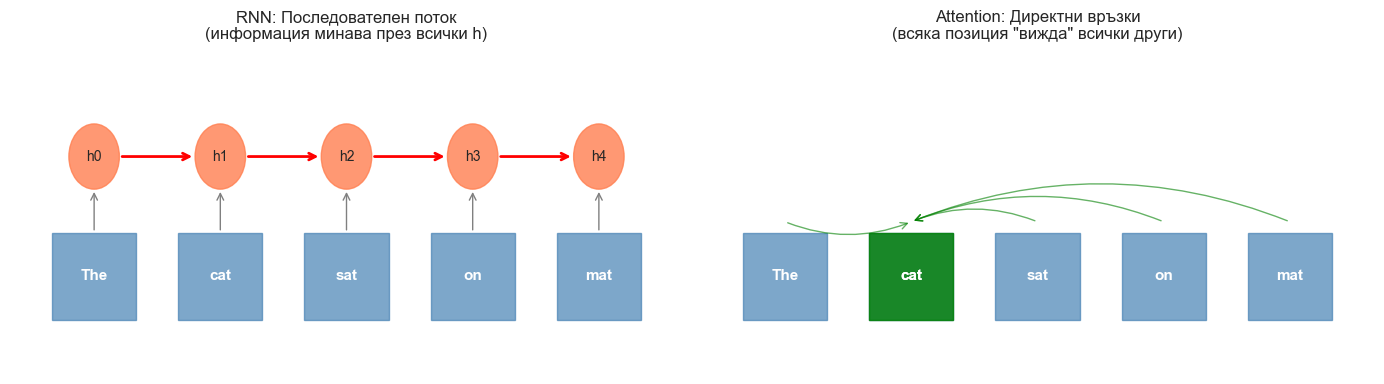

In [3]:
# Визуализация: RNN информационен поток
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# RNN: последователен поток
ax = axes[0]
tokens_rnn = ['The', 'cat', 'sat', 'on', 'mat']
n = len(tokens_rnn)

for i, tok in enumerate(tokens_rnn):
    ax.add_patch(plt.Rectangle((i*1.5, 0), 1, 0.8, fill=True, color='steelblue', alpha=0.7))
    ax.text(i*1.5 + 0.5, 0.4, tok, ha='center', va='center', fontsize=11, color='white', fontweight='bold')
    
    # Hidden state
    ax.add_patch(plt.Circle((i*1.5 + 0.5, 1.5), 0.3, color='coral', alpha=0.8))
    ax.text(i*1.5 + 0.5, 1.5, f'h{i}', ha='center', va='center', fontsize=10)
    
    # Връзка от token към hidden
    ax.annotate('', xy=(i*1.5 + 0.5, 1.2), xytext=(i*1.5 + 0.5, 0.8),
                arrowprops=dict(arrowstyle='->', color='gray'))
    
    # Връзка между hidden states
    if i > 0:
        ax.annotate('', xy=(i*1.5 + 0.2, 1.5), xytext=((i-1)*1.5 + 0.8, 1.5),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax.set_xlim(-0.5, n*1.5)
ax.set_ylim(-0.5, 2.5)
ax.axis('off')
ax.set_title('RNN: Последователен поток\n(информация минава през всички h)', fontsize=12)

# Attention: директни връзки
ax = axes[1]
for i, tok in enumerate(tokens_rnn):
    ax.add_patch(plt.Rectangle((i*1.5, 0), 1, 0.8, fill=True, color='steelblue', alpha=0.7))
    ax.text(i*1.5 + 0.5, 0.4, tok, ha='center', va='center', fontsize=11, color='white', fontweight='bold')

# Директни връзки (attention)
target_idx = 1  # "cat"
ax.add_patch(plt.Rectangle((target_idx*1.5, 0), 1, 0.8, fill=True, color='green', alpha=0.8))
ax.text(target_idx*1.5 + 0.5, 0.4, tokens_rnn[target_idx], ha='center', va='center', 
        fontsize=11, color='white', fontweight='bold')

for i in range(n):
    if i != target_idx:
        ax.annotate('', xy=(target_idx*1.5 + 0.5, 0.9), xytext=(i*1.5 + 0.5, 0.9),
                    arrowprops=dict(arrowstyle='->', color='green', alpha=0.6, 
                                   connectionstyle='arc3,rad=0.2'))

ax.set_xlim(-0.5, n*1.5)
ax.set_ylim(-0.5, 2.5)
ax.axis('off')
ax.set_title('Attention: Директни връзки\n(всяка позиция "вижда" всички други)', fontsize=12)

plt.tight_layout()
plt.show()

### Ключовият insight

> **Какво ако всяка позиция може директно да "види" всяка друга позиция?**

- Без последователна обработка
- Без информационно "гърло" през hidden state
- **Това е attention!**

---
## 2. Self-Attention: Основната идея

### Интуиция: Динамично насочване на информация

Всяка позиция "пита": **Кои други позиции са релевантни за мен?**

Пример: "The cat sat on the mat because **it** was tired"
- "it" трябва да "погледне" към "cat" за да разбере на какво се отнася
- Различно изречение → различен attention pattern

### Query-Key-Value Framework

**Аналогия: Търсене в база данни**

| Компонент | Въпрос | Роля |
|-----------|--------|------|
| **Query (Q)** | Какво търся? | Позицията, която "пита" |
| **Key (K)** | Какво предлагам? | Идентификатор на информация |
| **Value (V)** | Каква информация съдържам? | Съдържанието |

**Механизъм:** Q пита "Кои K-та ми съответстват?", после взима съответните V-та.

### Изчисляване на Q, K, V

**Вход:** Последователност от embeddings $X \in \mathbb{R}^{n \times d}$

**Научени проекции:**
$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Където:
- $W_Q, W_K \in \mathbb{R}^{d \times d_k}$
- $W_V \in \mathbb{R}^{d \times d_v}$

Всяка позиция генерира своите Q, K, V вектори.

In [4]:
# Step-by-step пример с конкретни числа
# 3 токена: "The", "cat", "sat"
# d = 4 (размерност на embedding)
# d_k = d_v = 3 (размерност на Q, K, V)

# Embeddings (опростени)
X = np.array([
    [1.0, 0.0, 1.0, 0.5],  # "The"
    [0.0, 1.0, 0.5, 1.0],  # "cat"
    [0.5, 0.5, 1.0, 0.0],  # "sat"
])

# Научени тегла (в реалност - чрез backprop)
np.random.seed(42)
d, d_k = 4, 3
W_Q = np.random.randn(d, d_k) * 0.5
W_K = np.random.randn(d, d_k) * 0.5
W_V = np.random.randn(d, d_k) * 0.5

# Изчисляваме Q, K, V
Q = X @ W_Q
K = X @ W_K
V = X @ W_V

print("Входни embeddings X (3 токена × 4 измерения):")
print(X)
print(f"\nQ = X @ W_Q (3 × 3):")
print(Q.round(3))
print(f"\nK = X @ W_K (3 × 3):")
print(K.round(3))
print(f"\nV = X @ W_V (3 × 3):")
print(V.round(3))

Входни embeddings X (3 токена × 4 измерения):
[[1.  0.  1.  0.5]
 [0.  1.  0.5 1. ]
 [0.5 0.5 1.  0. ]]

Q = X @ W_Q (3 × 3):
[[ 1.174  0.199 -0.027]
 [ 1.428 -0.157 -0.467]
 [ 1.295  0.291 -0.131]]

K = X @ W_K (3 × 3):
[[-0.389 -1.646 -0.486]
 [-0.621 -0.826 -0.189]
 [-0.534 -1.438  0.38 ]]

V = X @ W_V (3 × 3):
[[-0.837  1.187 -0.887]
 [-0.491  0.574 -0.76 ]
 [-0.343  0.804 -0.367]]


### Attention Scores: Измерване на релевантност

**Dot product** между query и keys измерва сходство:

$$\text{score}_{ij} = q_i \cdot k_j$$

**Матрична форма:** $\text{Scores} = QK^T$ (размер: $n \times n$)

По-висок score = по-релевантно.

Attention Scores = Q @ K.T:
[[-0.771 -0.888 -0.923]
 [-0.071 -0.669 -0.715]
 [-0.919 -1.019 -1.159]]

Размер: (3, 3) (всяка позиция към всяка)


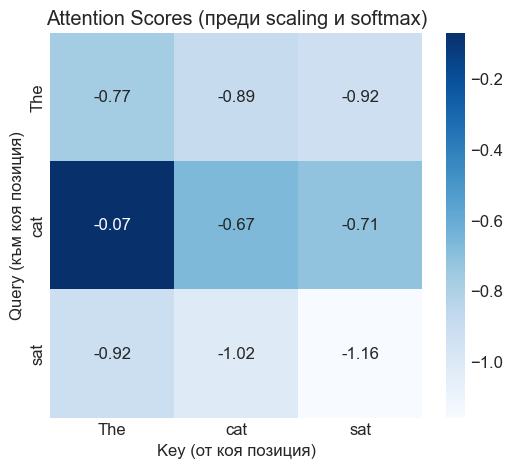

In [5]:
# Изчисляваме attention scores
scores = Q @ K.T

print("Attention Scores = Q @ K.T:")
print(scores.round(3))
print("\nРазмер:", scores.shape, "(всяка позиция към всяка)")

# Визуализация
tokens = ['The', 'cat', 'sat']
plt.figure(figsize=(6, 5))
sns.heatmap(scores, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=tokens, yticklabels=tokens)
plt.xlabel('Key (от коя позиция)')
plt.ylabel('Query (към коя позиция)')
plt.title('Attention Scores (преди scaling и softmax)')
plt.show()

### Scaled Dot-Product Attention

**Проблем:** При високи измерения dot products стават много големи.

Големи стойности → softmax сатурира → vanishing gradients.

**Решение:** Скалиране с $\sqrt{d_k}$:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

### Защо $\sqrt{d_k}$?

Ако $q, k$ имат единична variance:
- $q \cdot k = \sum_{i=1}^{d_k} q_i k_i$
- Variance на сумата е $d_k$
- Делейки на $\sqrt{d_k}$, възстановяваме единична variance

In [6]:
# Демонстрация на scaling ефекта
d_k = 3  # нашият пример
scaled_scores = scores / np.sqrt(d_k)

print(f"Оригинални scores (max={scores.max():.2f}):")
print(scores.round(3))
print(f"\nСкалирани scores / √{d_k} (max={scaled_scores.max():.2f}):")
print(scaled_scores.round(3))

Оригинални scores (max=-0.07):
[[-0.771 -0.888 -0.923]
 [-0.071 -0.669 -0.715]
 [-0.919 -1.019 -1.159]]

Скалирани scores / √3 (max=-0.04):
[[-0.445 -0.513 -0.533]
 [-0.041 -0.386 -0.413]
 [-0.53  -0.588 -0.669]]


### Softmax: От scores към тегла

$$\text{weight}_{ij} = \frac{\exp(\text{score}_{ij})}{\sum_k \exp(\text{score}_{ik})}$$

- Всеки ред сумира до 1 (вероятностно разпределение)
- Всяка позиция получава претеглена комбинация от всички values

In [7]:
# Softmax функция
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # numerical stability
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# Изчисляваме attention weights
attention_weights = softmax(scaled_scores)

print("Attention Weights (след softmax):")
print(attention_weights.round(3))
print(f"\nСума по редове: {attention_weights.sum(axis=1).round(3)}")

Attention Weights (след softmax):
[[0.351 0.328 0.321]
 [0.417 0.295 0.288]
 [0.355 0.335 0.309]]

Сума по редове: [1. 1. 1.]


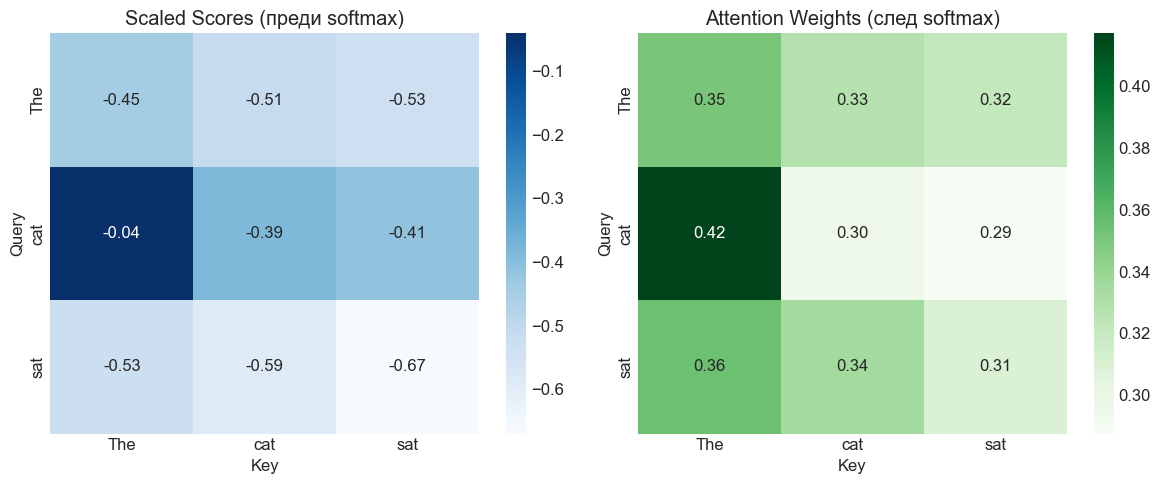

In [8]:
# Визуализация на attention weights
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scores
sns.heatmap(scaled_scores, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=tokens, yticklabels=tokens, ax=axes[0])
axes[0].set_title('Scaled Scores (преди softmax)')
axes[0].set_xlabel('Key'); axes[0].set_ylabel('Query')

# Weights
sns.heatmap(attention_weights, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=tokens, yticklabels=tokens, ax=axes[1])
axes[1].set_title('Attention Weights (след softmax)')
axes[1].set_xlabel('Key'); axes[1].set_ylabel('Query')

plt.tight_layout()
plt.show()

### Финален изход

Претеглена сума на values:

$$\text{output}_i = \sum_j \text{weight}_{ij} \cdot v_j$$

**Матрична форма:** $\text{Output} = \text{Weights} \cdot V$

Размер на изхода: същият като входа ($n \times d_v$)

In [9]:
# Финален изход на attention
output = attention_weights @ V

print("Value vectors V:")
print(V.round(3))
print(f"\nAttention output = Weights @ V:")
print(output.round(3))
print(f"\nРазмер: {output.shape} (същият като входа)")

Value vectors V:
[[-0.837  1.187 -0.887]
 [-0.491  0.574 -0.76 ]
 [-0.343  0.804 -0.367]]

Attention output = Weights @ V:
[[-0.565  0.863 -0.678]
 [-0.593  0.896 -0.7  ]
 [-0.568  0.863 -0.684]]

Размер: (3, 3) (същият като входа)


In [10]:
# Пълна имплементация на scaled dot-product attention
def scaled_dot_product_attention(Q, K, V):
    """Scaled Dot-Product Attention от scratch."""
    d_k = K.shape[-1]
    
    # 1. Изчисляваме scores
    scores = Q @ K.T
    
    # 2. Скалираме
    scaled_scores = scores / np.sqrt(d_k)
    
    # 3. Softmax
    attention_weights = softmax(scaled_scores)
    
    # 4. Претеглена сума на values
    output = attention_weights @ V
    
    return output, attention_weights

# Проверка
out, weights = scaled_dot_product_attention(Q, K, V)
print("Scaled Dot-Product Attention:")
print(f"  Input shape: {X.shape}")
print(f"  Output shape: {out.shape}")
print(f"  Weights shape: {weights.shape}")

Scaled Dot-Product Attention:
  Input shape: (3, 4)
  Output shape: (3, 3)
  Weights shape: (3, 3)


---
## 3. Свойства на Self-Attention

### Всяка позиция се свързва с всяка

- O(n²) връзки между позиции
- Без информационно "гърло"
- Дълги зависимости се обработват директно

**Сравнение с RNN:** Информацията трябва да "премине" през всички междинни стъпки.

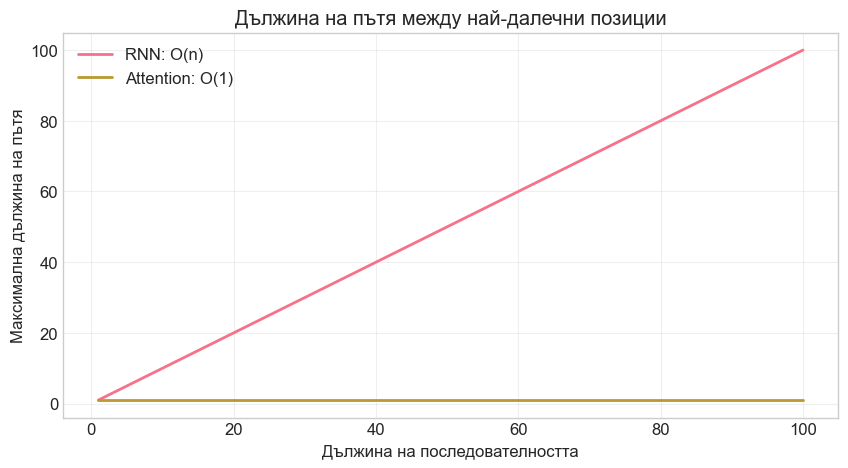

За последователност от 100 токена:
  RNN: до 100 стъпки за информация от началото до края
  Attention: 1 стъпка (директна връзка)


In [11]:
# Path length comparison
seq_lengths = np.arange(1, 101)

# RNN: информация трябва да мине през всички позиции
rnn_max_path = seq_lengths  # O(n)

# Attention: директна връзка
attn_max_path = np.ones_like(seq_lengths)  # O(1)

plt.figure(figsize=(10, 5))
plt.plot(seq_lengths, rnn_max_path, label='RNN: O(n)', linewidth=2)
plt.plot(seq_lengths, attn_max_path, label='Attention: O(1)', linewidth=2)
plt.xlabel('Дължина на последователността')
plt.ylabel('Максимална дължина на пътя')
plt.title('Дължина на пътя между най-далечни позиции')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("За последователност от 100 токена:")
print(f"  RNN: до 100 стъпки за информация от началото до края")
print(f"  Attention: 1 стъпка (директна връзка)")

### Permutation Equivariance

**Проблем:** Ако размесим входните позиции, изходът се размесва по същия начин.

"The cat sat" и "sat cat The" произвеждат същия attention pattern!

**Attention е позиционно-агностичен.**

**Решение:** Positional encodings (следващата секция)

In [12]:
# Демонстрация на permutation equivariance
# Оригинален ред: ["The", "cat", "sat"]
X_original = X.copy()

# Разменяме: ["sat", "cat", "The"]
perm = [2, 1, 0]
X_permuted = X[perm]

# Изчисляваме Q, K, V за двата
Q_orig, K_orig, V_orig = X_original @ W_Q, X_original @ W_K, X_original @ W_V
Q_perm, K_perm, V_perm = X_permuted @ W_Q, X_permuted @ W_K, X_permuted @ W_V

# Attention
out_orig, weights_orig = scaled_dot_product_attention(Q_orig, K_orig, V_orig)
out_perm, weights_perm = scaled_dot_product_attention(Q_perm, K_perm, V_perm)

print("Оригинален ред: ['The', 'cat', 'sat']")
print("Weights:")
print(weights_orig.round(3))

print("\nРазменен ред: ['sat', 'cat', 'The']")
print("Weights:")
print(weights_perm.round(3))

print("\n→ Attention не 'знае' реда! Нужни са positional encodings.")

Оригинален ред: ['The', 'cat', 'sat']
Weights:
[[0.351 0.328 0.321]
 [0.417 0.295 0.288]
 [0.355 0.335 0.309]]

Разменен ред: ['sat', 'cat', 'The']
Weights:
[[0.309 0.335 0.355]
 [0.288 0.295 0.417]
 [0.321 0.328 0.351]]

→ Attention не 'знае' реда! Нужни са positional encodings.


### Пълна паралелизация

- Всички позиции се изчисляват едновременно
- Без последователни зависимости при forward pass
- Огромно GPU ускорение спрямо RNN
- **Критично за обучение в мащаб**

### Изчислителна сложност

| Операция | Сложност |
|----------|----------|
| Време | O(n²d) — квадратична по дължина |
| Памет | O(n²) за attention weights |

**Имплициране:** Ограничава максималната дължина на последователността.

**Следваща лекция:** Flash Attention, sliding window и други оптимизации.

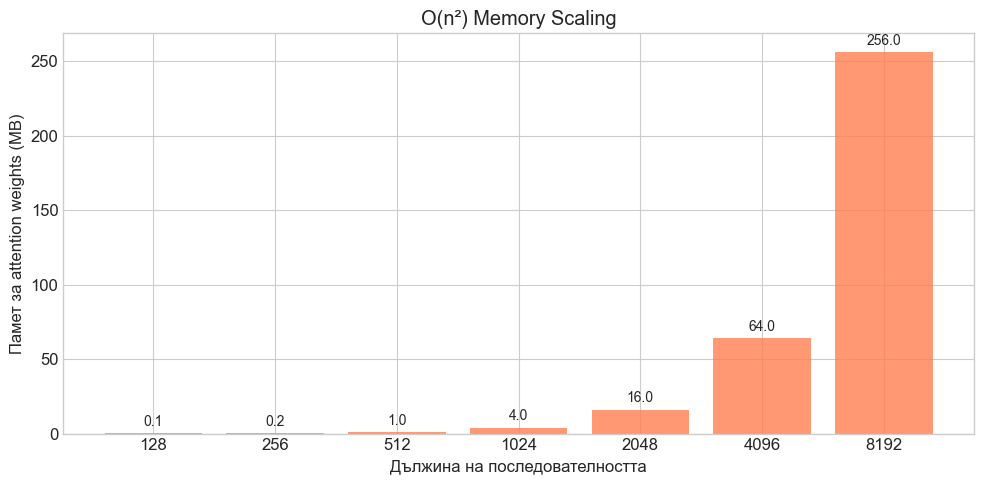

При 8K токена: 256 MB само за attention weights!


In [13]:
# Memory scaling visualization
seq_lengths = np.array([128, 256, 512, 1024, 2048, 4096, 8192])
memory_mb = (seq_lengths ** 2 * 4) / (1024 ** 2)  # 4 bytes per float32

plt.figure(figsize=(10, 5))
plt.bar(range(len(seq_lengths)), memory_mb, color='coral', alpha=0.8)
plt.xticks(range(len(seq_lengths)), [str(s) for s in seq_lengths])
plt.xlabel('Дължина на последователността')
plt.ylabel('Памет за attention weights (MB)')
plt.title('O(n²) Memory Scaling')

for i, (s, m) in enumerate(zip(seq_lengths, memory_mb)):
    plt.text(i, m + 5, f'{m:.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"При 8K токена: {memory_mb[-1]:.0f} MB само за attention weights!")

---
## 4. Positional Encodings

### Проблемът с позициите

Self-attention третира входа като **множество**, не като последователност.

"dog bites man" vs "man bites dog" → идентични без позиции!

**Решение:** Добавяме информация за позицията.

### Learned Positional Embeddings

Добавяме научени вектори за всяка позиция:

$$x_i' = x_i + p_i$$

Където $P \in \mathbb{R}^{L_{max} \times d}$ е научена матрица.

**Предимство:** Просто и ефективно.

**Недостатък:** Не може да генерализира над $L_{max}$.

In [14]:
# Learned positional embeddings
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)
    
    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device)
        return x + self.pos_embedding(positions)

# Пример
pos_enc = LearnedPositionalEncoding(max_len=512, d_model=64)
x = torch.randn(2, 10, 64)  # batch=2, seq_len=10, d=64
x_with_pos = pos_enc(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {x_with_pos.shape}")
print(f"Positional embedding parameters: {pos_enc.pos_embedding.weight.shape}")

Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
Positional embedding parameters: torch.Size([512, 64])


### Sinusoidal Positional Encoding (Original Transformer)

$$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d})$$
$$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d})$$

**Защо тази формула?**

- Различни честоти за различни измерения
- Ниски измерения: висока честота (различават близки позиции)
- Високи измерения: ниска честота (различават далечни позиции)
- **Ключово свойство:** $PE_{pos+k}$ може да се изрази като линейна комбинация на $PE_{pos}$

In [15]:
# Sinusoidal positional encoding implementation
def sinusoidal_positional_encoding(max_len, d_model):
    """Генерира sinusoidal positional encoding."""
    pe = np.zeros((max_len, d_model))
    position = np.arange(max_len)[:, np.newaxis]
    
    # Честоти за различни измерения
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
    # Четни измерения: sin
    pe[:, 0::2] = np.sin(position * div_term)
    # Нечетни измерения: cos
    pe[:, 1::2] = np.cos(position * div_term)
    
    return pe

# Генерираме за 100 позиции, 64 измерения
pe = sinusoidal_positional_encoding(100, 64)
print(f"Positional encoding shape: {pe.shape}")
print(f"\nПозиция 0: {pe[0, :8].round(3)}")
print(f"Позиция 1: {pe[1, :8].round(3)}")
print(f"Позиция 50: {pe[50, :8].round(3)}")

Positional encoding shape: (100, 64)

Позиция 0: [0. 1. 0. 1. 0. 1. 0. 1.]
Позиция 1: [0.841 0.54  0.682 0.732 0.533 0.846 0.409 0.912]
Позиция 50: [-0.262  0.965 -0.203  0.979  0.157 -0.988  0.787 -0.617]


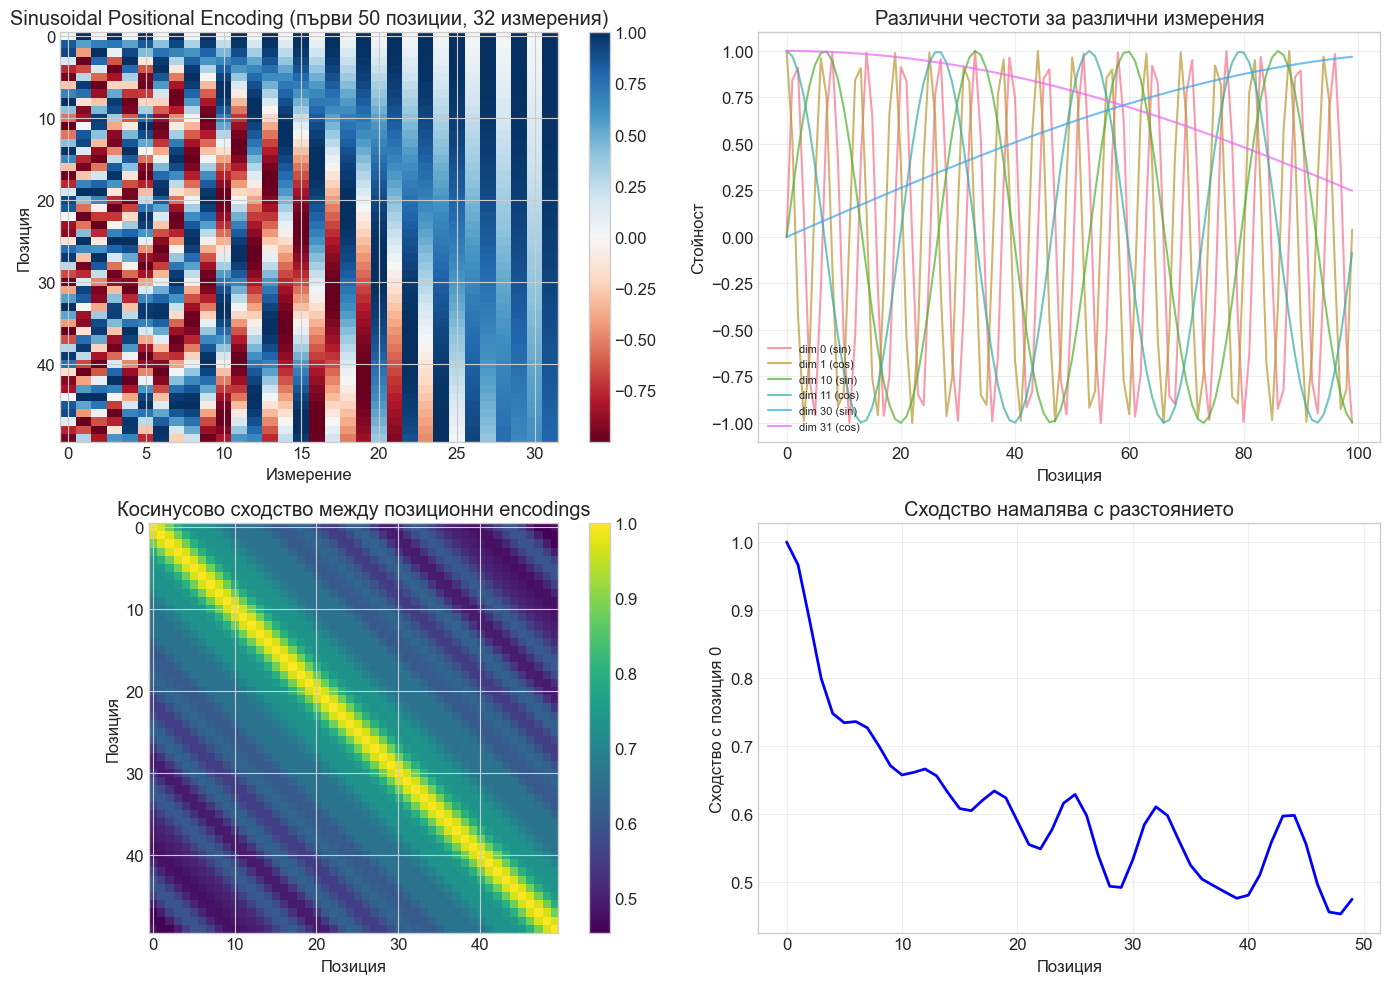

In [16]:
# Визуализация на sinusoidal encoding
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Пълна heatmap
ax = axes[0, 0]
im = ax.imshow(pe[:50, :32], aspect='auto', cmap='RdBu')
ax.set_xlabel('Измерение')
ax.set_ylabel('Позиция')
ax.set_title('Sinusoidal Positional Encoding (първи 50 позиции, 32 измерения)')
plt.colorbar(im, ax=ax)

# Няколко измерения
ax = axes[0, 1]
positions = np.arange(100)
for dim in [0, 1, 10, 11, 30, 31]:
    label = f'dim {dim} ({"sin" if dim % 2 == 0 else "cos"})'
    ax.plot(positions, pe[:, dim], label=label, alpha=0.7)
ax.set_xlabel('Позиция')
ax.set_ylabel('Стойност')
ax.set_title('Различни честоти за различни измерения')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Сходство между позиции
ax = axes[1, 0]
pe_normalized = pe / np.linalg.norm(pe, axis=1, keepdims=True)
similarity = pe_normalized @ pe_normalized.T
im = ax.imshow(similarity[:50, :50], cmap='viridis')
ax.set_xlabel('Позиция')
ax.set_ylabel('Позиция')
ax.set_title('Косинусово сходство между позиционни encodings')
plt.colorbar(im, ax=ax)

# Сходство от позиция 0
ax = axes[1, 1]
ax.plot(similarity[0, :50], 'b-', linewidth=2)
ax.set_xlabel('Позиция')
ax.set_ylabel('Сходство с позиция 0')
ax.set_title('Сходство намалява с разстоянието')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Защо addition, а не concatenation?

- Запазва размерността
- Embeddings и позиции взаимодействат чрез attention
- Работи емпирично добре

In [17]:
# PyTorch имплементация на sinusoidal PE
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (не се обучава)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        return x + self.pe[:, :x.size(1)]

# Пример
pos_enc = SinusoidalPositionalEncoding(d_model=64)
x = torch.randn(2, 100, 64)  # Може да е по-дълго от training!
x_with_pos = pos_enc(x)
print(f"Input: {x.shape} → Output: {x_with_pos.shape}")

Input: torch.Size([2, 100, 64]) → Output: torch.Size([2, 100, 64])


### Ефект на positional encodings върху attention

Нека видим как позициите променят attention pattern-а.

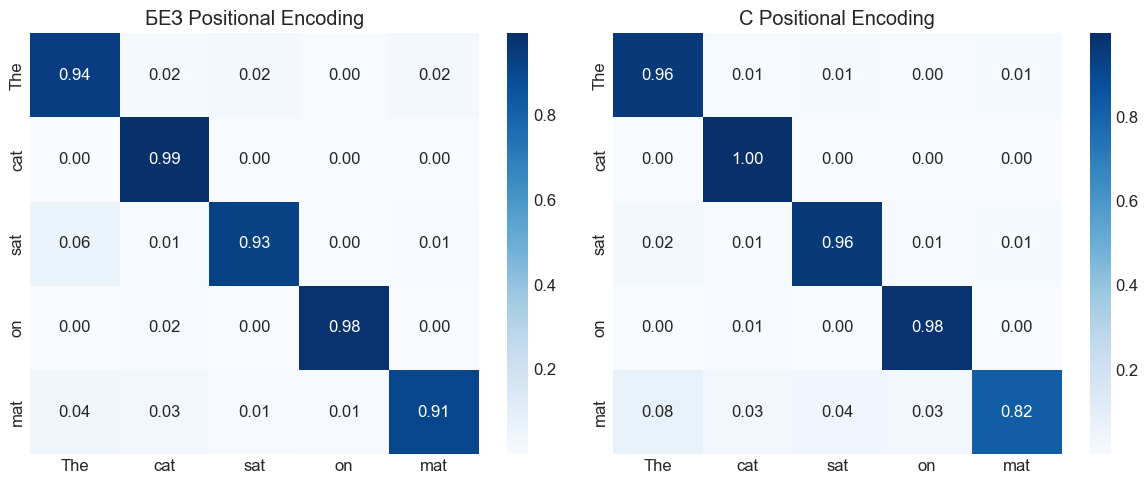

Забележете: с PE има тенденция за локално attention (близки позиции).


In [18]:
# Сравнение: с и без positional encoding
d_model = 16
seq_len = 5
tokens_demo = ['The', 'cat', 'sat', 'on', 'mat']

# Симулираме embeddings
np.random.seed(123)
X_demo = np.random.randn(seq_len, d_model)

# Добавяме positional encoding
pe_demo = sinusoidal_positional_encoding(seq_len, d_model)
X_with_pos = X_demo + pe_demo

# Q, K, V проекции (просто identity за демонстрация)
def simple_attention(X):
    scores = X @ X.T / np.sqrt(X.shape[-1])
    return softmax(scores)

weights_no_pos = simple_attention(X_demo)
weights_with_pos = simple_attention(X_with_pos)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(weights_no_pos, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=tokens_demo, yticklabels=tokens_demo, ax=axes[0])
axes[0].set_title('БЕЗ Positional Encoding')

sns.heatmap(weights_with_pos, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=tokens_demo, yticklabels=tokens_demo, ax=axes[1])
axes[1].set_title('С Positional Encoding')

plt.tight_layout()
plt.show()

print("Забележете: с PE има тенденция за локално attention (близки позиции).")

### Модерна алтернатива: Rotary Position Embeddings (RoPE)

- Кодира позицията директно в attention изчислението
- По-добра за дълги последователности
- **Използва се от:** LLaMA, Mistral, повечето модерни модели

**Детайли в Лекция 5.**

---
## 5. Multi-Head Attention

### Ограничение на single attention

Един attention head = един pattern на слой.

Но думите се свързват по **много начини едновременно**:

| Тип | Пример |
|-----|--------|
| Синтактичен | subject-verb agreement |
| Семантичен | coreference ("it" → "cat") |
| Позиционен | съседни думи |
| Тематичен | свързани по тема думи |

### Multi-Head решението

Изпълняваме **h паралелни attention операции**:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

където $\text{head}_i = \text{Attention}(XW_Q^i, XW_K^i, XW_V^i)$

Всеки head има **собствени Q, K, V проекции**.

### Размерности

Ако model dimension е $d_{model}$ и имаме $h$ heads:
- Всеки head има размерност $d_k = d_v = d_{model} / h$
- **Пример:** $d_{model} = 512$, $h = 8$ → всеки head е 64-dimensional
- Output projection $W^O \in \mathbb{R}^{hd_v \times d_{model}}$

**Общо параметри:** Същият брой като един голям head!

In [19]:
# Multi-Head Attention от scratch
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Проекции за Q, K, V (всички heads наведнъж)
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # 1. Linear projections
        Q = self.W_q(x)  # [batch, seq_len, d_model]
        K = self.W_k(x)
        V = self.W_v(x)
        
        # 2. Split into heads: [batch, seq_len, n_heads, d_k]
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k)
        
        # 3. Transpose for attention: [batch, n_heads, seq_len, d_k]
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)
        
        # 4. Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = F.softmax(scores, dim=-1)
        
        # 5. Apply attention to values
        context = torch.matmul(attention_weights, V)  # [batch, n_heads, seq_len, d_k]
        
        # 6. Concatenate heads
        context = context.transpose(1, 2).contiguous()  # [batch, seq_len, n_heads, d_k]
        context = context.view(batch_size, seq_len, self.d_model)
        
        # 7. Final linear projection
        output = self.W_o(context)
        
        return output, attention_weights

# Пример
mha = MultiHeadAttention(d_model=64, n_heads=8)
x = torch.randn(2, 10, 64)  # batch=2, seq_len=10, d_model=64

output, attn_weights = mha(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"  (batch, n_heads, seq_len_q, seq_len_k)")

Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
Attention weights shape: torch.Size([2, 8, 10, 10])
  (batch, n_heads, seq_len_q, seq_len_k)


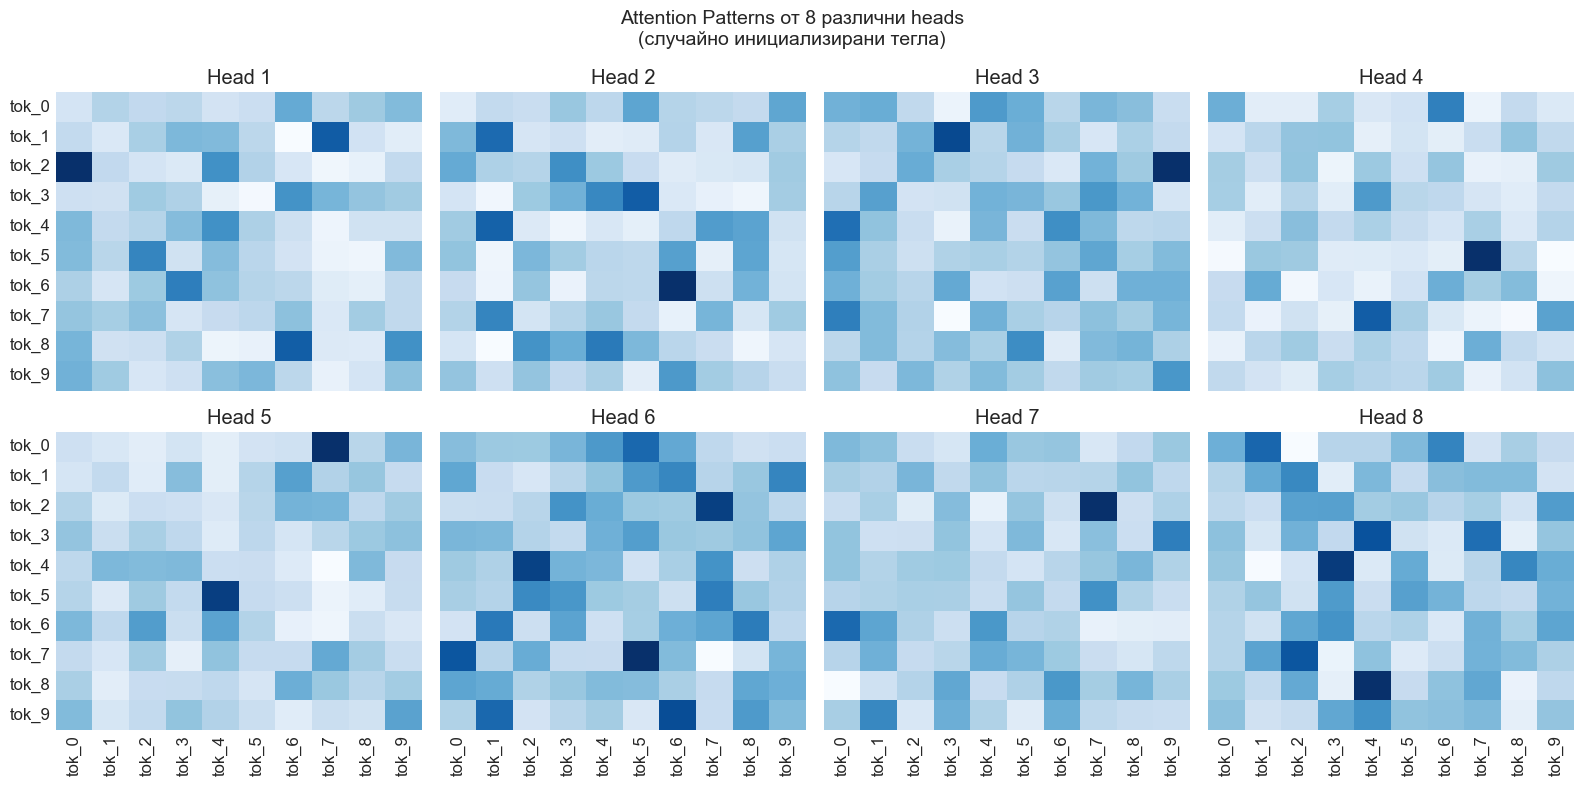

След обучение, различните heads се специализират за различни pattern-и.


In [20]:
# Визуализация на различни heads
# Използваме един batch елемент
attn = attn_weights[0].detach().numpy()  # [n_heads, seq_len, seq_len]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
tokens_mha = [f'tok_{i}' for i in range(10)]

for i, ax in enumerate(axes.flat):
    sns.heatmap(attn[i], cmap='Blues', ax=ax,
                xticklabels=tokens_mha if i >= 4 else False,
                yticklabels=tokens_mha if i % 4 == 0 else False,
                cbar=False)
    ax.set_title(f'Head {i+1}')

plt.suptitle('Attention Patterns от 8 различни heads\n(случайно инициализирани тегла)', fontsize=14)
plt.tight_layout()
plt.show()

print("След обучение, различните heads се специализират за различни pattern-и.")

### Какво научават различните heads?

Изследвания (BERTology) показват специализация:

| Head | Pattern |
|------|--------|
| 1 | Синтактична структура (subject-verb) |
| 2 | Coreference (pronouns → antecedents) |
| 3 | Локални зависимости (съседни токени) |
| 4+ | По-трудни за интерпретиране, но комплементарни |

Някои heads са redundant и могат да бъдат "pruned".

### Защо multi-head работи

- **Ensemble** от attention patterns
- Различни "лещи" за един и същ вход
- Redundancy за robustness
- Увеличена expressiveness

### Типични хиперпараметри

| Model | d_model | n_heads | d_k |
|-------|---------|---------|-----|
| BERT-base | 768 | 12 | 64 |
| GPT-2 | 768 | 12 | 64 |
| GPT-3 | 12288 | 96 | 128 |
| LLaMA 7B | 4096 | 32 | 128 |

---
## 6. Attention на практика

### Causal (Masked) Attention

За **autoregressive generation**: позиция i може да вижда само позиции ≤ i.

**Имплементация:** Mask с -∞ преди softmax.

Създава **lower-triangular** attention pattern.

**Използва се от:** GPT, LLaMA, всички decoder-only модели.

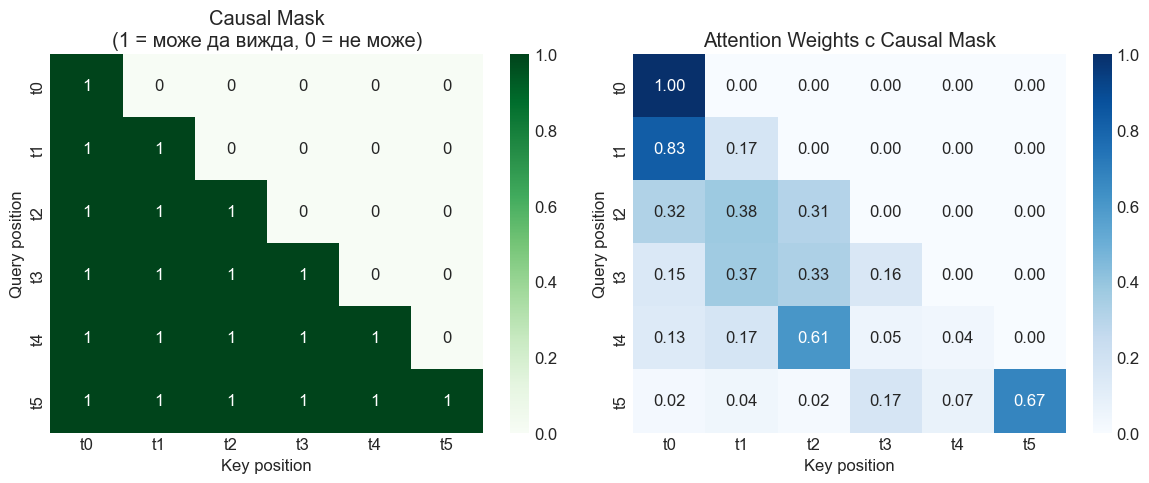

t3 може да вижда само t0, t1, t2, t3 (не t4, t5).


In [21]:
# Causal mask implementation
def create_causal_mask(seq_len):
    """Създава causal mask (lower triangular)."""
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    return mask == 0  # True where attention is allowed

# Визуализация
seq_len = 6
mask = create_causal_mask(seq_len)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mask
ax = axes[0]
sns.heatmap(mask.float().numpy(), annot=True, fmt='.0f', cmap='Greens',
            xticklabels=[f't{i}' for i in range(seq_len)],
            yticklabels=[f't{i}' for i in range(seq_len)], ax=ax)
ax.set_title('Causal Mask\n(1 = може да вижда, 0 = не може)')
ax.set_xlabel('Key position')
ax.set_ylabel('Query position')

# Effect on attention
ax = axes[1]
# Random scores
torch.manual_seed(42)
scores = torch.randn(seq_len, seq_len)
scores_masked = scores.masked_fill(~mask, -1e9)
attn_causal = F.softmax(scores_masked, dim=-1)

sns.heatmap(attn_causal.numpy(), annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[f't{i}' for i in range(seq_len)],
            yticklabels=[f't{i}' for i in range(seq_len)], ax=ax)
ax.set_title('Attention Weights с Causal Mask')
ax.set_xlabel('Key position')
ax.set_ylabel('Query position')

plt.tight_layout()
plt.show()

print("t3 може да вижда само t0, t1, t2, t3 (не t4, t5).")

In [22]:
# Causal attention в код
def causal_attention(Q, K, V):
    """Scaled dot-product attention с causal mask."""
    d_k = K.shape[-1]
    seq_len = Q.shape[0]
    
    # Scores
    scores = Q @ K.T / np.sqrt(d_k)
    
    # Apply causal mask
    mask = np.triu(np.ones((seq_len, seq_len)), k=1) * -1e9
    scores = scores + mask
    
    # Softmax
    weights = softmax(scores)
    
    # Output
    return weights @ V, weights

# Demo
np.random.seed(42)
seq_len, d = 5, 4
Q = np.random.randn(seq_len, d)
K = np.random.randn(seq_len, d)
V = np.random.randn(seq_len, d)

out, weights = causal_attention(Q, K, V)
print("Causal attention weights (lower triangular):")
print(weights.round(3))

Causal attention weights (lower triangular):
[[1.    0.    0.    0.    0.   ]
 [0.519 0.481 0.    0.    0.   ]
 [0.294 0.45  0.255 0.    0.   ]
 [0.287 0.282 0.169 0.262 0.   ]
 [0.208 0.296 0.079 0.237 0.18 ]]


### Cross-Attention

Queries от една последователност, keys/values от друга.

**Използва се в:** Encoder-decoder модели (T5, BART).

**Пример:** Machine translation — decoder "пита" encoder outputs.

**Не е фокусът ни:** Decoder-only доминира в модерните LLM.

### Attention Patterns в реални модели

- Някои heads научават интерпретируеми patterns
- Много heads са redundant (могат да бъдат pruned)
- **Внимание:** Attention ≠ explanation (продължаващ дебат)

### Често срещани проблеми

| Проблем | Описание |
|---------|----------|
| Attention collapse | Всички позиции attend към едно място |
| Dead heads | Heads, които не научават полезни patterns |
| Numerical instability | Нужна е внимателна softmax имплементация |

---
## 7. Интуиция: Attention като изчисление

### Какво може да изчисли Attention?

| Операция | Как |
|----------|-----|
| **Копиране** | Attend силно към една позиция, копирай value |
| **Усредняване** | Uniform attention = mean pooling |
| **Pattern matching** | Q-K similarity позволява content-based retrieval |
| **Композиция** | Stack layers за сложни изчисления |

In [23]:
# Демонстрация: Attention като copy
# Ако един елемент има много висок score, attention го "копира"

# Values
V_demo = np.array([
    [1.0, 0.0, 0.0],  # "The"
    [0.0, 1.0, 0.0],  # "cat"
    [0.0, 0.0, 1.0],  # "sat"
])

# Ако attention за позиция 2 е [0.0, 1.0, 0.0]
# (силно attend към "cat")
attention_copy = np.array([0.0, 1.0, 0.0])
output_copy = attention_copy @ V_demo

print("Values:")
for i, name in enumerate(['The', 'cat', 'sat']):
    print(f"  {name}: {V_demo[i]}")

print(f"\nAttention weights: {attention_copy}")
print(f"Output: {output_copy}")
print("\n→ 'Копира' value на 'cat'!")

Values:
  The: [1. 0. 0.]
  cat: [0. 1. 0.]
  sat: [0. 0. 1.]

Attention weights: [0. 1. 0.]
Output: [0. 1. 0.]

→ 'Копира' value на 'cat'!


In [24]:
# Демонстрация: Attention като averaging
attention_avg = np.array([1/3, 1/3, 1/3])  # Uniform
output_avg = attention_avg @ V_demo

print(f"Uniform attention: {attention_avg}")
print(f"Output: {output_avg.round(3)}")
print("\n→ Mean pooling!")

Uniform attention: [0.33333333 0.33333333 0.33333333]
Output: [0.333 0.333 0.333]

→ Mean pooling!


### Attention като Soft Dictionary Lookup

| Компонент | Роля |
|-----------|------|
| Keys | Какво е съхранено |
| Values | Съдържанието |
| Query | Ключ за търсене |
| Output | Soft комбинация от matching entries |

### Защо е толкова мощно?

- **Dynamic routing:** Изчислението зависи от входа
- **Без фиксирана свързаност** (за разлика от convolutions)
- **Научава какво е релевантно** от данните
- **Мащабира** с повече heads и layers

---
## 8. Обобщение и мост към следващата лекция

### Ключови изводи

1. **Attention позволява директни връзки** между всички позиции
2. **Query-Key-Value:** Динамично, content-based насочване на информация
3. **Scaling с $\sqrt{d_k}$** предотвратява gradient saturation
4. **Positional encodings** добавят информация за реда
5. **Multi-head attention** улавя множество типове релации
6. **Causal masking** за autoregressive generation

### Следваща лекция: Transformer Architecture

Attention е ядрото. **Лекция 5** добавя:

- Feed-forward networks
- Residual connections и layer normalization
- Stacking layers
- Модерни варианти: MQA, GQA, Flash Attention
- Long context: от 512 до 1M токена

---
## Ресурси

### Основни статии
1. **"Attention Is All You Need"** — Vaswani et al. (2017) — Оригиналният transformer
2. **"Neural Machine Translation by Jointly Learning to Align and Translate"** — Bahdanau et al. (2014) — Оригинален attention в seq2seq

### Анализ и интерпретация
1. **"A Multiscale Visualization of Attention"** — Vig (2019) — BertViz tool
2. **"Analyzing Multi-Head Self-Attention"** — Voita et al. (2019) — Head specialization

### Online ресурси
1. **The Illustrated Transformer** — Jay Alammar — Отлични визуализации
2. **The Annotated Transformer** — Harvard NLP — PyTorch имплементация
3. **Stanford CS224N** — Lecture on Transformers

---
## Упражнения

### Упражнение 1: Attention от scratch
- Имплементирайте scaled dot-product attention в NumPy
- Верифицирайте с PyTorch имплементация
- Визуализирайте attention weights

### Упражнение 2: Positional encoding exploration
- Имплементирайте sinusoidal encoding
- Тествайте extrapolation: train на 100, test на 200
- Сравнете с learned embeddings

### Упражнение 3: Multi-head vs single-head
- Обучете малък модел с 1 head vs 8 heads
- Сравнете performance на проста задача
- Анализирайте какво научават различните heads

### Упражнение 4: Causal attention за генерация
- Имплементирайте causal masking
- Изградете прост character-level generator
- Демонстрирайте autoregressive generation

---
## Край на Лекция 4

**Въпроси?**

---

**Следваща лекция:** Transformer Architecture и Long Context